In [6]:
import os, sys
import numpy as np
import pandas as pd

from config_local import local_config

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
train = pd.read_csv(local_config.TRAIN_PROCESS6_CSV)
test  = pd.read_csv(local_config.TEST_PROCESS6_CSV)
testRaw = pd.read_csv(local_config.TEST_CSV, index_col="Id")

In [9]:
y = train['logSP']
X = train.drop(['logSP'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
alphas = [
    0.0001, 0.0005, 0.0007, 0.0008, 0.0009,
    0.0010, 0.0011, 0.0012, 0.0013, 0.0015,
    0.002, 0.005, 0.01
]

l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

max_iter = 20000  # a bit higher for safety

best_alpha = None
best_l1_ratio = None
best_rmse = float("inf")

print("Searching best hyperparameters for ElasticNet...\n")

for a in alphas:
    for l1 in l1_ratios:
        model = ElasticNet(alpha=a, l1_ratio=l1, max_iter=max_iter)
        model.fit(X_train, y_train)

        # Predict in log space
        y_pred = model.predict(X_test)

        # Back to original scale (since y is log-transformed)
        y_pred_real = np.exp(y_pred)
        y_test_real = np.exp(y_test)

        mse = mean_squared_error(y_test_real, y_pred_real)
        rmse = mse ** 0.5

        print(f"alpha={a:.6f}, l1_ratio={l1:.1f} -> RMSE={rmse:.2f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = a
            best_l1_ratio = l1

print("\n===============================")
print(f"Best ElasticNet → alpha={best_alpha}, l1_ratio={best_l1_ratio}, RMSE={best_rmse:.2f}")
print("===============================\n")

# Refit best ElasticNet on the same train set
best_model = ElasticNet(alpha=best_alpha,
                        l1_ratio=best_l1_ratio,
                        max_iter=max_iter)
best_model.fit(X_train, y_train)

# Optional: check RMSE again on holdout
y_pred = best_model.predict(X_test)
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)
rmse_check = mean_squared_error(y_test_real, y_pred_real)
print(f"RMSE with best ElasticNet: {rmse_check:.2f}")

# Predict on Kaggle test set
test_pred_log = best_model.predict(test)
test_pred_real = np.expm1(test_pred_log)

# Build submission (adapt paths to your config)
submission = pd.DataFrame({
    "Id": testRaw.index,
    "SalePrice": test_pred_real
})

Searching best hyperparameters for ElasticNet...

alpha=0.000100, l1_ratio=0.1 -> RMSE=21357.99
alpha=0.000100, l1_ratio=0.3 -> RMSE=21128.20
alpha=0.000100, l1_ratio=0.5 -> RMSE=20887.84
alpha=0.000100, l1_ratio=0.7 -> RMSE=20659.67
alpha=0.000100, l1_ratio=0.9 -> RMSE=20438.53
alpha=0.000500, l1_ratio=0.1 -> RMSE=20411.22
alpha=0.000500, l1_ratio=0.3 -> RMSE=19945.68
alpha=0.000500, l1_ratio=0.5 -> RMSE=19848.29
alpha=0.000500, l1_ratio=0.7 -> RMSE=19785.66
alpha=0.000500, l1_ratio=0.9 -> RMSE=19707.02
alpha=0.000700, l1_ratio=0.1 -> RMSE=20164.31
alpha=0.000700, l1_ratio=0.3 -> RMSE=19863.05
alpha=0.000700, l1_ratio=0.5 -> RMSE=19776.20
alpha=0.000700, l1_ratio=0.7 -> RMSE=19678.62
alpha=0.000700, l1_ratio=0.9 -> RMSE=19633.31
alpha=0.000800, l1_ratio=0.1 -> RMSE=20075.15
alpha=0.000800, l1_ratio=0.3 -> RMSE=19826.58
alpha=0.000800, l1_ratio=0.5 -> RMSE=19745.00
alpha=0.000800, l1_ratio=0.7 -> RMSE=19655.15
alpha=0.000800, l1_ratio=0.9 -> RMSE=19620.32
alpha=0.000900, l1_ratio=0.1 -

In [11]:
submission = pd.DataFrame({
    "Id": testRaw.index,
    "SalePrice": test_pred_real
})

out_path = os.path.join(local_config.SUBMISSIONS_DIR, "elasticNetModel.csv")
submission.to_csv(out_path, index=False)

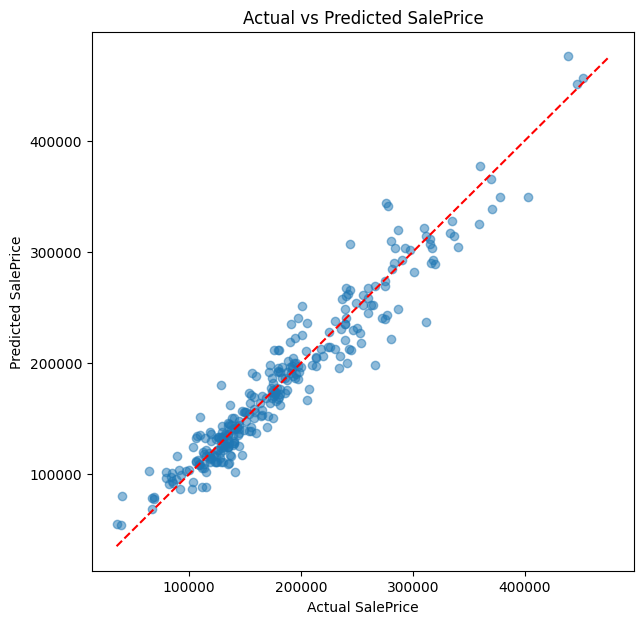

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# If you used log1p:
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred)

plt.figure(figsize=(7,7))
plt.scatter(y_true, y_pred, alpha=0.5)

# perfect prediction line
line_min = min(y_true.min(), y_pred.min())
line_max = max(y_true.max(), y_pred.max())
plt.plot([line_min, line_max], [line_min, line_max], 'r--')

plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")

plt.show()